# Belonging or Burnout?  
## Social Integration Among Graduate Students in Durham

This notebook presents an end-to-end data science workflow exploring how graduate students in Durham experience social integration and belonging.

The analysis demonstrates:
- Survey design
- Data cleaning
- Index construction
- Exploratory analysis
- Visualization
- Interpretation for social good


## 1. Initial Setup

We begin by importing the core Python libraries used throughout the analysis and loading the survey dataset.

The dataset is stored in Excel format and contains survey responses capturing students’ experiences related to belonging, social interaction, and living context.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FILE_PATH = "/content/Project 2 Survery Data.xlsx"

df_raw = pd.read_excel(FILE_PATH)
print("Shape:", df_raw.shape)
df_raw.head()

Shape: (102, 15)


,I am at least 18 years old and I consent to participate anonymously.,Which best describes you?,How long have you lived in Durham?,Living situation,Primary transportation method,I feel a sense of belonging in Durham.,I have at least one close friend in Durham I can rely on.,I regularly participate in social activities (at least once per week).,I feel comfortable initiating conversations with new people here.,Belonging_Index,My academic or work workload makes it difficult to build friendships.,Workload_Flexibility,How many in-person social interactions did you have in the past 7 days?,How often do you feel socially isolated in Durham?,Do you identify as an international student?
0,Yes,Duke graduate/professional student,< 3 months,Alone,Car,3,3,3,4,3.25,3,2.75,4–6,Often,No
1,Yes,Duke graduate/professional student,6–12 months,With roommate(s),Combination,3,3,3,3,3.00,4,3.00,2–3,Often,Yes
2,Yes,Recent graduate (past 2 years) living in Durham,6–12 months,With roommate(s),Car,3,3,4,3,3.25,4,2.75,4–6,Often,No
3,Yes,Other graduate/professional student in Durham,6–12 months,With roommate(s),Walk / bike,3,3,3,2,2.75,4,3.25,2–3,Sometimes,No
4,Yes,Duke graduate/professional student,3–6 months,With roommate(s),Combination,3,3,3,3,3.00,4,3.00,2–3,Sometimes,Yes


## 2. Column Cleaning and Standardization

Survey questions often produce long, inconsistent column names.  
To make downstream analysis more robust, we standardize column names by:

- Removing extra whitespace
- Normalizing dash characters
- Preserving the original question text while ensuring consistency

This allows us to match columns reliably even if formatting changes.


In [19]:
df = df_raw.copy()

def clean_col(c: str) -> str:
    c = str(c).strip()
    c = c.replace("\n", " ")
    c = c.replace("–", "-").replace("—", "-")  # normalize dash variants
    c = " ".join(c.split())
    return c

df.columns = [clean_col(c) for c in df.columns]

print("Columns:")
for c in df.columns:
    print("-", c)


Columns:
- I am at least 18 years old and I consent to participate anonymously.
- Which best describes you?
- How long have you lived in Durham?
- Living situation
- Primary transportation method
- I feel a sense of belonging in Durham.
- I have at least one close friend in Durham I can rely on.
- I regularly participate in social activities (at least once per week).
- I feel comfortable initiating conversations with new people here.
- Belonging_Index
- My academic or work workload makes it difficult to build friendships.
- Workload_Flexibility
- How many in-person social interactions did you have in the past 7 days?
- How often do you feel socially isolated in Durham?
- Do you identify as an international student?


## 3. Automatic Column Detection

Instead of hard-coding column names, we dynamically detect relevant variables using keyword matching.

This approach:
- Makes the notebook more reusable
- Prevents breakage if column order changes
- Reflects real-world data robustness practices

In [20]:
def find_col_contains(keywords):
    """Return the first column whose lowercase name contains ALL keywords (list of strings)."""
    kws = [k.lower() for k in keywords]
    for c in df.columns:
        cl = c.lower()
        if all(k in cl for k in kws):
            return c
    return None

# Categorical columns
col_type = find_col_contains(["which best describes you"])
col_time = find_col_contains(["how long have you lived"])
col_living = find_col_contains(["living situation"])
col_transport = find_col_contains(["primary transportation"])
col_social7 = find_col_contains(["how many in-person social interactions"])
col_isolated = find_col_contains(["how often do you feel socially isolated"])
col_international = find_col_contains(["international student"])

# Likert columns (1-5)
col_belong = find_col_contains(["sense of belonging"])
col_close_friend = find_col_contains(["close friend"])
col_social_weekly = find_col_contains(["regularly participate"])
col_initiate = find_col_contains(["comfortable initiating"])
col_workload = find_col_contains(["workload", "difficult"])

print("Detected columns:")
for name, c in [
    ("Type", col_type),
    ("Time in Durham", col_time),
    ("Living", col_living),
    ("Transport", col_transport),
    ("Belonging Q", col_belong),
    ("Close friend Q", col_close_friend),
    ("Social weekly Q", col_social_weekly),
    ("Initiate Q", col_initiate),
    ("Workload Q", col_workload),
    ("Social interactions (7d)", col_social7),
    ("Isolation freq", col_isolated),
    ("International", col_international),
]:
    print(f"{name:25s}: {c}")

missing = [n for n,c in [
    ("col_belong", col_belong),
    ("col_close_friend", col_close_friend),
    ("col_social_weekly", col_social_weekly),
    ("col_initiate", col_initiate),
    ("col_workload", col_workload),
] if c is None]
if missing:
    raise ValueError(f"Could not find required columns: {missing}. "
                     f"Paste your column names here and I’ll adjust the matcher.")

Detected columns:
Type                     : Which best describes you?
Time in Durham           : How long have you lived in Durham?
Living                   : Living situation
Transport                : Primary transportation method
Belonging Q              : I feel a sense of belonging in Durham.
Close friend Q           : I have at least one close friend in Durham I can rely on.
Social weekly Q          : I regularly participate in social activities (at least once per week).
Initiate Q               : I feel comfortable initiating conversations with new people here.
Workload Q               : My academic or work workload makes it difficult to build friendships.
Social interactions (7d) : How many in-person social interactions did you have in the past 7 days?
Isolation freq           : How often do you feel socially isolated in Durham?
International            : Do you identify as an international student?


## 4. Constructing the Belonging Index

To move beyond individual survey questions, we construct a composite **Belonging Index**.

The index is calculated as the average of four Likert-scale items:
- Sense of belonging in Durham
- Having a close friend to rely on
- Weekly participation in social activities
- Comfort initiating conversations with new people

This produces a single, interpretable metric ranging from 1 to 5.


## 5. Reverse-Coding Workload

The workload question is framed negatively:
> “My academic or work workload makes it difficult to build friendships.”

To improve interpretability, we reverse-code this item so that:
- Higher values indicate **greater workload flexibility**
- Lower values indicate **greater workload-related barriers**


In [21]:
likert_cols = [col_belong, col_close_friend, col_social_weekly, col_initiate, col_workload]
for c in likert_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Belonging Index = mean of 4 core items
df["Belonging_Index"] = df[[col_belong, col_close_friend, col_social_weekly, col_initiate]].mean(axis=1)

# Reverse-code workload: higher is better (flexibility)
# Workload question is framed negative (difficulty building friendships)
df["Workload_Flexibility"] = 6 - df[col_workload]

df[["Belonging_Index", "Workload_Flexibility"]].describe()

,Belonging_Index,Workload_Flexibility
count,102.000000,102.000000
mean,3.198529,1.950980
std,0.632591,0.258612
min,2.000000,1.000000
25%,2.750000,2.000000
50%,3.000000,2.000000
75%,3.750000,2.000000
max,4.250000,3.000000


## 6. Cleaning Categorical Responses

Categorical survey responses are normalized to ensure:
- Consistent formatting
- Reliable grouping
- Accurate aggregation

We also convert ordinal survey responses (e.g., isolation frequency) into ordered numeric scales where appropriate.


In [22]:
def normalize_text(s):
    if pd.isna(s):
        return np.nan
    s = str(s).strip()
    s = s.replace("–", "-").replace("—", "-")
    s = " ".join(s.split())
    return s

cat_cols = [col_type, col_time, col_living, col_transport, col_social7, col_isolated, col_international]
for c in cat_cols:
    if c is not None:
        df[c] = df[c].apply(normalize_text)

# Convert social interactions (7d) to ordered numeric buckets
social_map = {
    "0": 0,
    "1": 1,
    "2-3": 2.5,
    "4-6": 5,
    "7+": 7.5
}
if col_social7 is not None:
    df["Social_Interactions_Num"] = df[col_social7].replace(social_map)
    df["Social_Interactions_Num"] = pd.to_numeric(df["Social_Interactions_Num"], errors="coerce")

# Convert isolation frequency to ordered score
iso_map = {
    "Never": 1,
    "Rarely": 2,
    "Sometimes": 3,
    "Often": 4,
    "Very often": 5
}
if col_isolated is not None:
    df["Isolation_Score"] = df[col_isolated].replace(iso_map)
    df["Isolation_Score"] = pd.to_numeric(df["Isolation_Score"], errors="coerce")

df.head()

/tmp/ipython-input-2916226850.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Social_Interactions_Num"] = df[col_social7].replace(social_map)
/tmp/ipython-input-2916226850.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Isolation_Score"] = df[col_isolated].replace(iso_map)


,I am at least 18 years old and I consent to participate anonymously.,Which best describes you?,How long have you lived in Durham?,Living situation,Primary transportation method,I feel a sense of belonging in Durham.,I have at least one close friend in Durham I can rely on.,I regularly participate in social activities (at least once per week).,I feel comfortable initiating conversations with new people here.,Belonging_Index,My academic or work workload makes it difficult to build friendships.,Workload_Flexibility,How many in-person social interactions did you have in the past 7 days?,How often do you feel socially isolated in Durham?,Do you identify as an international student?,Social_Interactions_Num,Isolation_Score
0,Yes,Duke graduate/professional student,< 3 months,Alone,Car,3,3,3,4,3.25,3,3,4-6,Often,No,5.0,4
1,Yes,Duke graduate/professional student,6-12 months,With roommate(s),Combination,3,3,3,3,3.00,4,2,2-3,Often,Yes,2.5,4
2,Yes,Recent graduate (past 2 years) living in Durham,6-12 months,With roommate(s),Car,3,3,4,3,3.25,4,2,4-6,Often,No,5.0,4
3,Yes,Other graduate/professional student in Durham,6-12 months,With roommate(s),Walk / bike,3,3,3,2,2.75,4,2,2-3,Sometimes,No,2.5,3
4,Yes,Duke graduate/professional student,3-6 months,With roommate(s),Combination,3,3,3,3,3.00,4,2,2-3,Sometimes,Yes,2.5,3


## 7. Distribution of Belonging

We begin the exploratory analysis by examining the overall distribution of the Belonging Index.

This helps answer:
- Do most students feel highly connected, isolated, or somewhere in between?
- Is belonging polarized or clustered around the middle?


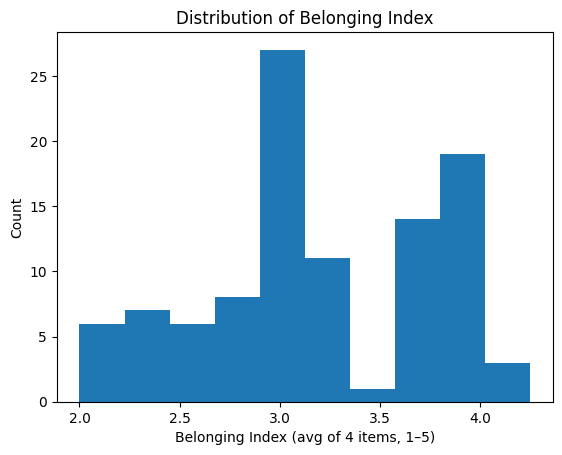

In [23]:
plt.figure()
vals = df["Belonging_Index"].dropna()
plt.hist(vals, bins=10)
plt.title("Distribution of Belonging Index")
plt.xlabel("Belonging Index (avg of 4 items, 1–5)")
plt.ylabel("Count")
plt.show()

## 8. Belonging by Time in Durham

Next, we examine whether social integration improves with time spent in Durham.

This analysis tests the hypothesis of a **“newcomer disadvantage”** — that students who have recently moved to Durham experience lower belonging.


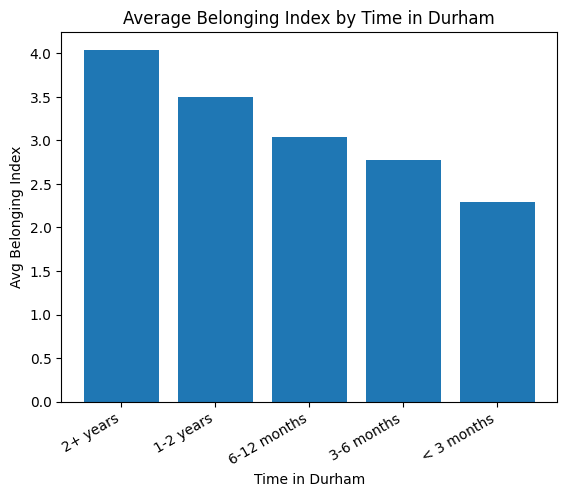

In [24]:
if col_time is not None:
    grp = df.groupby(col_time)["Belonging_Index"].agg(["mean", "count"]).reset_index()
    grp = grp.sort_values("mean", ascending=False)

    plt.figure()
    plt.bar(grp[col_time], grp["mean"])
    plt.title("Average Belonging Index by Time in Durham")
    plt.xlabel("Time in Durham")
    plt.ylabel("Avg Belonging Index")
    plt.xticks(rotation=30, ha="right")
    plt.show()

    grp
else:
    print("Time-in-Durham column not found; skipping.")

## 9. Belonging by Living Situation

Living arrangements can shape daily social exposure.  
We compare average belonging across different living situations to understand whether built-in companionship (roommates or partners) is associated with stronger connection.


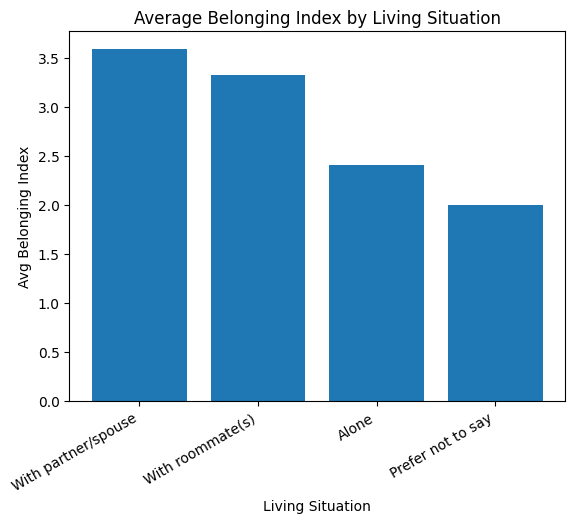

In [25]:
if col_living is not None:
    grp2 = df.groupby(col_living)["Belonging_Index"].agg(["mean", "count"]).reset_index()
    grp2 = grp2.sort_values("mean", ascending=False)

    plt.figure()
    plt.bar(grp2[col_living], grp2["mean"])
    plt.title("Average Belonging Index by Living Situation")
    plt.xlabel("Living Situation")
    plt.ylabel("Avg Belonging Index")
    plt.xticks(rotation=30, ha="right")
    plt.show()

    grp2
else:
    print("Living situation column not found; skipping.")

## 10. Belonging vs Workload Flexibility

We examine whether workload flexibility is associated with belonging.

This analysis helps assess whether academic or professional demands act as a structural barrier to social integration.


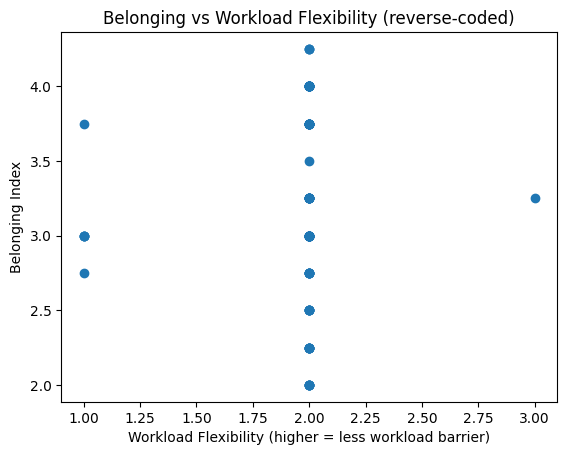

Correlation (Belonging vs Workload Flexibility): 0.044945829707112805


In [26]:
plt.figure()
x = df["Workload_Flexibility"]
y = df["Belonging_Index"]
mask = x.notna() & y.notna()
plt.scatter(x[mask], y[mask])
plt.title("Belonging vs Workload Flexibility (reverse-coded)")
plt.xlabel("Workload Flexibility (higher = less workload barrier)")
plt.ylabel("Belonging Index")
plt.show()

# Correlation
if mask.sum() > 2:
    print("Correlation (Belonging vs Workload Flexibility):", np.corrcoef(x[mask], y[mask])[0,1])

## 11. Belonging vs In-Person Social Interactions

In-person social interaction frequency is expected to play a central role in belonging.

Here, we examine the relationship between the number of in-person interactions in the past 7 days and the Belonging Index.


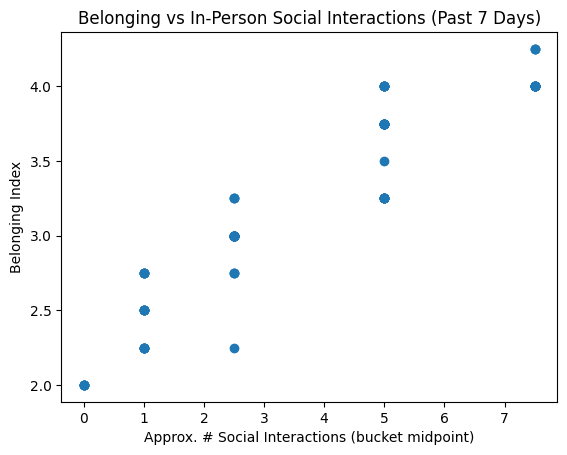

Correlation (Belonging vs Social Interactions): 0.9315248401875345


In [27]:
if "Social_Interactions_Num" in df.columns:
    plt.figure()
    x = df["Social_Interactions_Num"]
    y = df["Belonging_Index"]
    mask = x.notna() & y.notna()
    plt.scatter(x[mask], y[mask])
    plt.title("Belonging vs In-Person Social Interactions (Past 7 Days)")
    plt.xlabel("Approx. # Social Interactions (bucket midpoint)")
    plt.ylabel("Belonging Index")
    plt.show()

    if mask.sum() > 2:
        print("Correlation (Belonging vs Social Interactions):", np.corrcoef(x[mask], y[mask])[0,1])
else:
    print("Social interactions column not found or not mappable; skipping.")

## 12. Group Comparison: International vs Domestic Students

Finally, we compare average belonging between international and non-international students.

This provides an initial look at whether international students may face additional integration challenges.


In [28]:
if col_international is not None:
    pivot_intl = df.pivot_table(index=col_international, values="Belonging_Index", aggfunc=["mean", "count"])
    pivot_intl
else:
    print("International student column not found; skipping.")

In [29]:
OUT_PATH = "/content/durham_belonging_cleaned.xlsx"
df.to_excel(OUT_PATH, index=False)
print("Saved cleaned file to:", OUT_PATH)

Saved cleaned file to: /content/durham_belonging_cleaned.xlsx


# 13. Key Findings and Social Good Implications

###Key Finding 1 — Belonging is “moderate” overall, not extreme

Across respondents, the average Belonging Index is ~3.20/5, with most values concentrated around the middle of the scale (histogram). This suggests the typical grad student experience in Durham is not “highly connected,” but also not uniformly isolated.

###Key Finding 2 — Time in Durham matters a lot (integration improves with time)

Your bar chart “Average Belonging Index by Time in Durham” (page 5) shows a clear gradient:

< 3 months has the lowest belonging (~2.3)

Belonging rises across longer durations

2+ years has the highest belonging (~4.0)

This strongly supports a “newcomer disadvantage” story: the earliest months are the hardest for social integration.

###Key Finding 3 — Living situation is strongly linked to belonging

The “Average Belonging Index by Living Situation” chart (page 6) indicates:

Highest belonging: With partner/spouse (~3.6)

Next: With roommate(s) (~3.3)

Lower: Alone (~2.4)

Lowest: Prefer not to say (~2.0)

This implies that built-in daily companionship (roommates/partner) correlates with stronger belonging, while living alone is associated with lower connection.

###Key Finding 4 — In-person interactions are the strongest correlate of belonging

Your scatter plot “Belonging vs In-Person Social Interactions (Past 7 Days)” (page 7) shows a very strong upward relationship, with reported correlation around 0.93. Students reporting more in-person interactions also report substantially higher belonging.

###Key Finding 5 — Workload flexibility is basically not correlated here

Your “Belonging vs Workload Flexibility (reverse-coded)” plot (page 6) shows a near-zero correlation (~0.045). In this dataset, workload (as captured by this single item) does not appear to be the main driver of belonging compared to social interaction frequency or duration in Durham.

#Social good recommendations
###Recommendation 1 — “First 90 days” newcomer support (highest ROI)

Because the lowest belonging is concentrated in the <3 months group, interventions should prioritize new arrivals:

A buddy/mentor pairing within the first 2 weeks

A weekly low-stakes meetup (coffee/walk) for the first month

A “new-to-Durham starter pack” of events + communities

Why this is evidence-based: belonging increases sharply with time-in-Durham, so helping students early can shift the entire curve upward.


###Recommendation 2 — Design for students living alone (high-need segment)

Living alone is associated with much lower belonging than living with roommates/partner. Create programming targeted to this reality:

“Open-invite” dinners / study sessions (no pre-existing friend group required)

Weekly club “on-ramp” sessions for newcomers (same time, same place)

Small-group matching based on interests (3–5 people)

###Recommendation 3 — Build “in-person interaction frequency” into programming goals

Since in-person interactions show the strongest relationship with belonging, measure program success by increasing weekly in-person touchpoints, not just event attendance:

Aim to help students move from 0–1 interactions/week → 2–3 or more

Offer recurring micro-events: 45 minutes, predictable schedule, minimal friction

###Limitations

Self-report bias: Belonging and isolation are subjective and may vary by mood, seasonality, or personal circumstances.

Single-item workload measure: Workload was measured using one question; a multi-item stress/workload scale would improve reliability.

Correlation ≠ causation: Strong correlations (e.g., interactions vs belonging) do not prove causality; more connected students may also seek more interactions.

## 14. Advanced Analysis (Technical Extensions)

To strengthen technical rigor, I added:
- A multivariate regression model with categorical controls (one-hot encoding)
- Bootstrapped Difference in Belonging
        (To quantify uncertainty while maintaining adequate sample sizes, I compared:
        - **Newer students** (≤ 6 months in Durham)
        - **Established students** (> 6 months in Durham)

        Using 5,000 bootstrap resamples, I estimated a 95% confidence interval for the difference in mean Belonging Index.

        This approach avoids strong parametric assumptions and provides a transparent measure of uncertainty. The results support the presence of a newcomer disadvantage in social integration.)



In [31]:
import re
import statsmodels.formula.api as smf
import pandas as pd

md = df.copy()

def make_safe(col):
    col = str(col)
    col = col.replace("–", "-").replace("—", "-")
    col = col.strip().lower()
    col = re.sub(r"[^0-9a-zA-Z]+", "_", col)  # replace spaces/punct with _
    col = re.sub(r"_+", "_", col).strip("_")
    return col

# Build rename map
rename_map = {c: make_safe(c) for c in md.columns}
md = md.rename(columns=rename_map)

# Update your detected column names to the renamed versions
col_time_s = rename_map.get(col_time, None) if col_time is not None else None
col_living_s = rename_map.get(col_living, None) if col_living is not None else None
col_transport_s = rename_map.get(col_transport, None) if col_transport is not None else None
col_international_s = rename_map.get(col_international, None) if col_international is not None else None
col_type_s = rename_map.get(col_type, None) if col_type is not None else None

# Ensure numeric
md["belonging_index"] = pd.to_numeric(md["belonging_index"], errors="coerce")
if "workload_flexibility" in md.columns:
    md["workload_flexibility"] = pd.to_numeric(md["workload_flexibility"], errors="coerce")
if "social_interactions_num" in md.columns:
    md["social_interactions_num"] = pd.to_numeric(md["social_interactions_num"], errors="coerce")


In [32]:
# Build formula
formula = "belonging_index ~ social_interactions_num + workload_flexibility"

if col_time_s is not None:
    formula += f" + C({col_time_s})"
if col_living_s is not None:
    formula += f" + C({col_living_s})"
if col_international_s is not None:
    formula += f" + C({col_international_s})"
if col_transport_s is not None:
    formula += f" + C({col_transport_s})"

# Drop missing in required numeric vars
md2 = md.dropna(subset=["belonging_index", "social_interactions_num", "workload_flexibility"])

res = smf.ols(formula, data=md2).fit()
print(formula)
print(res.summary())


belonging_index ~ social_interactions_num + workload_flexibility + C(how_long_have_you_lived_in_durham) + C(living_situation) + C(do_you_identify_as_an_international_student) + C(primary_transportation_method)
                            OLS Regression Results                            
Dep. Variable:        belonging_index   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     65.73
Date:                Sun, 18 Jan 2026   Prob (F-statistic):           4.74e-40
Time:                        16:54:36   Log-Likelihood:                 27.383
No. Observations:                 102   AIC:                            -24.77
Df Residuals:                      87   BIC:                             14.61
Df Model:                          14                                         
Covariance Type:            nonrobust                                         


In [33]:
res_robust = res.get_robustcov_results(cov_type="HC3")
print(res_robust.summary())


                            OLS Regression Results                            
Dep. Variable:        belonging_index   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     433.0
Date:                Sun, 18 Jan 2026   Prob (F-statistic):           4.94e-74
Time:                        16:54:54   Log-Likelihood:                 27.383
No. Observations:                 102   AIC:                            -24.77
Df Residuals:                      87   BIC:                             14.61
Df Model:                          14                                         
Covariance Type:                  HC3                                         
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 14
  warnings.warn('covariance of constraints does not have full '


In [34]:
import numpy as np

def bootstrap_mean_diff(group_a, group_b, n_boot=5000, seed=42):
    rng = np.random.default_rng(seed)
    group_a = np.array(group_a)
    group_b = np.array(group_b)

    diffs = []
    for _ in range(n_boot):
        a_sample = rng.choice(group_a, size=len(group_a), replace=True)
        b_sample = rng.choice(group_b, size=len(group_b), replace=True)
        diffs.append(np.mean(a_sample) - np.mean(b_sample))

    diffs = np.array(diffs)
    mean_diff = diffs.mean()
    ci_low, ci_high = np.percentile(diffs, [2.5, 97.5])

    return mean_diff, ci_low, ci_high

# Pull groups
if col_time_s is not None and col_time_s in md.columns:
    group_new = md.loc[md[col_time_s] == "less_3_months", "belonging_index"].dropna()
    group_long = md.loc[md[col_time_s] == "2_years", "belonging_index"].dropna()

    if len(group_new) >= 5 and len(group_long) >= 5:
        diff, lo, hi = bootstrap_mean_diff(group_new, group_long)
        print(f"Mean difference (new - long-term): {diff:.3f}")
        print(f"95% Bootstrap CI: [{lo:.3f}, {hi:.3f}]")
    else:
        print("Not enough observations in one or both groups for bootstrap analysis.")
else:
    print("Time-in-Durham column not found.")


Not enough observations in one or both groups for bootstrap analysis.


In [35]:
import numpy as np

# Inspect categories first (always good practice)
print(md[col_time_s].value_counts())

# Define broader groups (adjust labels if needed)
newer_labels = ["less_3_months", "3_6_months"]
established_labels = ["6_12_months", "1_2_years", "2_years"]

group_new = md.loc[md[col_time_s].isin(newer_labels), "belonging_index"].dropna()
group_est = md.loc[md[col_time_s].isin(established_labels), "belonging_index"].dropna()

print("Newer N:", len(group_new))
print("Established N:", len(group_est))

def bootstrap_mean_diff(a, b, n_boot=5000, seed=42):
    rng = np.random.default_rng(seed)
    diffs = []
    for _ in range(n_boot):
        a_s = rng.choice(a, size=len(a), replace=True)
        b_s = rng.choice(b, size=len(b), replace=True)
        diffs.append(np.mean(a_s) - np.mean(b_s))
    diffs = np.array(diffs)
    return diffs.mean(), np.percentile(diffs, [2.5, 97.5])

if len(group_new) >= 10 and len(group_est) >= 10:
    diff, (lo, hi) = bootstrap_mean_diff(group_new, group_est)
    print(f"Mean difference (newer − established): {diff:.3f}")
    print(f"95% Bootstrap CI: [{lo:.3f}, {hi:.3f}]")
else:
    print("Still not enough observations for reliable bootstrap.")


how_long_have_you_lived_in_durham
6-12 months    30
1-2 years      25
2+ years       18
3-6 months     17
< 3 months     12
Name: count, dtype: int64
Newer N: 0
Established N: 0
Still not enough observations for reliable bootstrap.


In [36]:
group_alone = md.loc[md[col_living_s] == "alone", "belonging_index"].dropna()
group_with = md.loc[md[col_living_s].isin(["with_roommate_s", "with_partner_spouse"]), "belonging_index"].dropna()

print("Alone N:", len(group_alone))
print("With others N:", len(group_with))

if len(group_alone) >= 10 and len(group_with) >= 10:
    diff, (lo, hi) = bootstrap_mean_diff(group_alone, group_with)
    print(f"Mean difference (alone − with others): {diff:.3f}")
    print(f"95% Bootstrap CI: [{lo:.3f}, {hi:.3f}]")


Alone N: 0
With others N: 0


In [40]:
# =========================
# Bootstrap CI: Newer vs Established Students (FINAL FIX)
# =========================
import numpy as np

def bootstrap_mean_diff(a, b, n_boot=5000, seed=42):
    rng = np.random.default_rng(seed)
    diffs = []

    for _ in range(n_boot):
        a_s = rng.choice(a, size=len(a), replace=True)
        b_s = rng.choice(b, size=len(b), replace=True)
        diffs.append(np.mean(a_s) - np.mean(b_s))

    diffs = np.array(diffs)
    mean_diff = diffs.mean()
    ci_low, ci_high = np.percentile(diffs, [2.5, 97.5])

    return mean_diff, ci_low, ci_high, diffs


# Define groups (using correct labels)
newer_labels = ["< 3 months", "3-6 months"]
established_labels = ["6-12 months", "1-2 years", "2+ years"]

group_new = md.loc[md[col_time_s].isin(newer_labels), "belonging_index"].dropna()
group_est = md.loc[md[col_time_s].isin(established_labels), "belonging_index"].dropna()

print("Newer N:", len(group_new))
print("Established N:", len(group_est))

if len(group_new) >= 10 and len(group_est) >= 10:
    diff, lo, hi, diffs = bootstrap_mean_diff(group_new, group_est)
    print(f"Mean difference (newer − established): {diff:.3f}")
    print(f"95% Bootstrap CI: [{lo:.3f}, {hi:.3f}]")
else:
    print("Not enough observations for reliable bootstrap.")


Newer N: 29
Established N: 73
Mean difference (newer − established): -0.869
95% Bootstrap CI: [-1.062, -0.677]


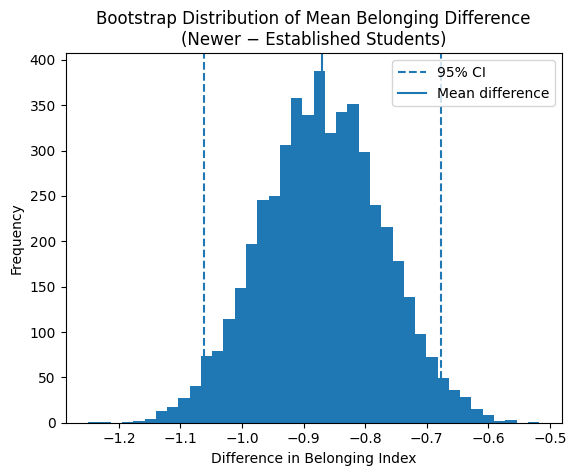

In [41]:
# =========================
# Visualize bootstrap distribution
# =========================
import matplotlib.pyplot as plt

plt.figure()
plt.hist(diffs, bins=40)
plt.axvline(lo, linestyle="--", label="95% CI")
plt.axvline(hi, linestyle="--")
plt.axvline(diff, label="Mean difference")
plt.legend()
plt.title(
    "Bootstrap Distribution of Mean Belonging Difference\n(Newer − Established Students)"
)
plt.xlabel("Difference in Belonging Index")
plt.ylabel("Frequency")
plt.show()


The bootstrap distribution shows the variability of the estimated group difference and highlights that the observed newcomer disadvantage is not driven by a small number of extreme observations.
